In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import Adam
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
import os
import pickle
from classifier_objects import Airfoil



2024-03-05 13:36:23.441643: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 13:36:23.473180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 13:36:23.473203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 13:36:23.474210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 13:36:23.480361: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 13:36:23.481580: I tensorflow/core/platform/cpu_feature_guard.cc:1

Epoch 1/100
650/650 - 3s - loss: 2.9679e-05 - mean_squared_error: 2.9679e-05 - val_loss: 1.3357e-05 - val_mean_squared_error: 1.3357e-05 - 3s/epoch - 4ms/step
Epoch 2/100
650/650 - 2s - loss: 1.0970e-05 - mean_squared_error: 1.0970e-05 - val_loss: 1.0928e-05 - val_mean_squared_error: 1.0928e-05 - 2s/epoch - 3ms/step
Epoch 3/100
650/650 - 2s - loss: 8.4561e-06 - mean_squared_error: 8.4561e-06 - val_loss: 6.1662e-06 - val_mean_squared_error: 6.1662e-06 - 2s/epoch - 3ms/step
Epoch 4/100
650/650 - 2s - loss: 7.3003e-06 - mean_squared_error: 7.3003e-06 - val_loss: 5.5634e-06 - val_mean_squared_error: 5.5634e-06 - 2s/epoch - 3ms/step
Epoch 5/100
650/650 - 2s - loss: 6.6140e-06 - mean_squared_error: 6.6140e-06 - val_loss: 1.1660e-05 - val_mean_squared_error: 1.1660e-05 - 2s/epoch - 3ms/step
Epoch 6/100
650/650 - 2s - loss: 5.9482e-06 - mean_squared_error: 5.9482e-06 - val_loss: 3.7409e-06 - val_mean_squared_error: 3.7409e-06 - 2s/epoch - 3ms/step
Epoch 7/100
650/650 - 2s - loss: 5.2924e-06 - 

/home/sari/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


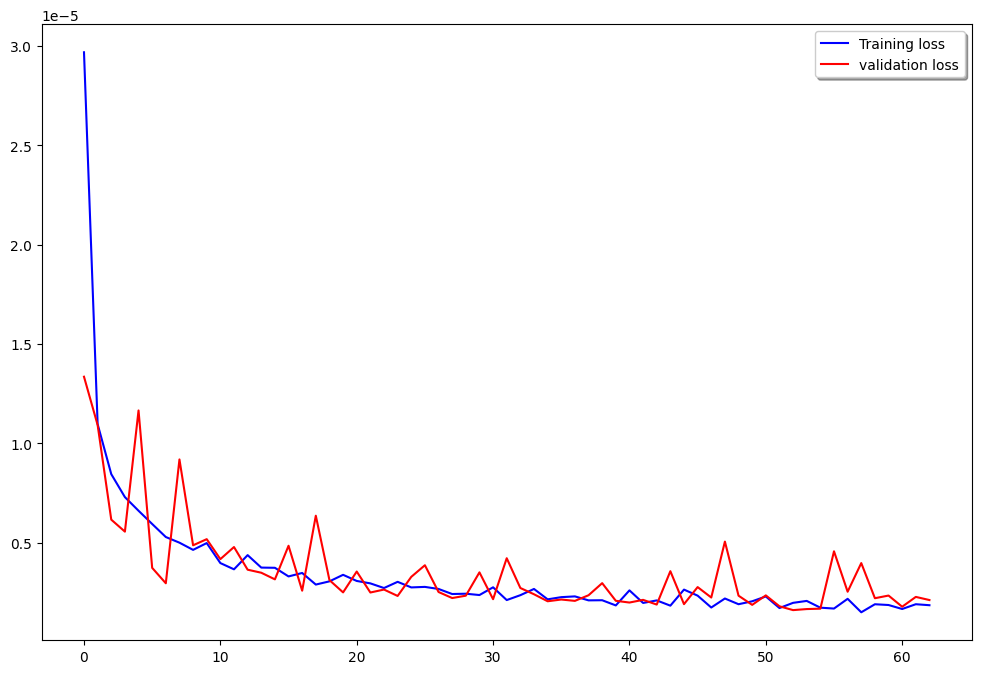

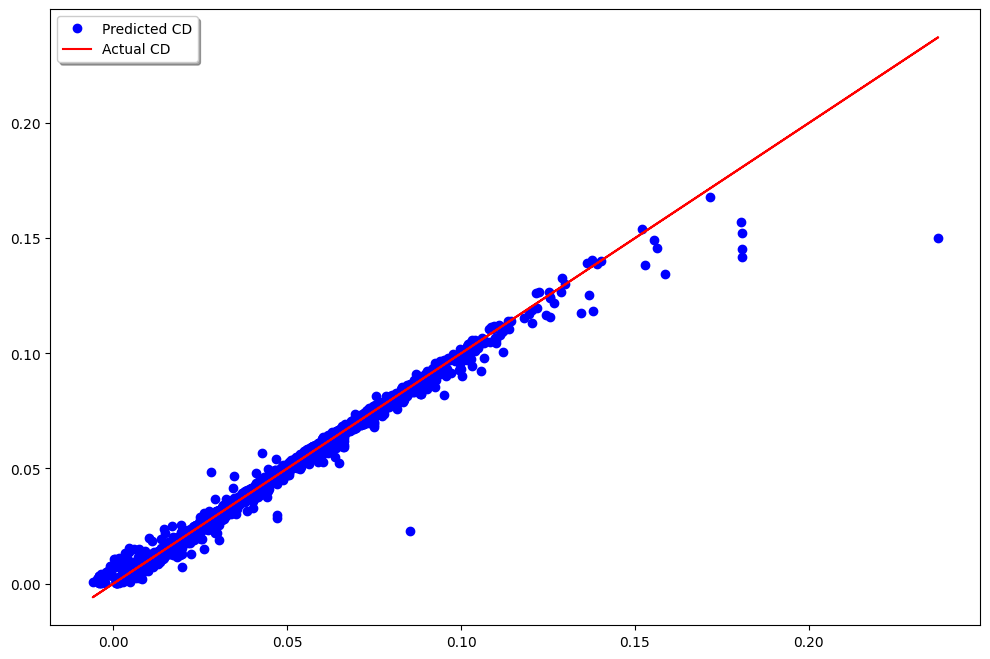

In [5]:
# Load dataset
x = np.loadtxt('input_data.txt')
DM = np.loadtxt('output_data.txt')

CD = DM[:,2]

x = x/np.amax(x, axis=0) # Normalize the data

# Split the dataset into training, validation and test sets
x_train, x_test, CD_train, CD_test = train_test_split(x, CD, test_size=0.1, random_state=42)
x_train, x_val, CD_train, CD_val = train_test_split(x_train, CD_train, test_size=0.1, random_state=42)

# Create the model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=5))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="linear"))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(x_train, CD_train, epochs=100, batch_size=256, validation_data=(x_val, CD_val), callbacks=[early_stopping], verbose=2)

# Evaluate the model
scores = model.evaluate(x_test, CD_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax.legend(loc='best', shadow=True)

# Predict the CD
CD_pred = model.predict(x_test)

# Plot the predicted CD vs the actual CD
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(CD_test, CD_pred, 'o', color='b', label="Predicted CD")
ax.plot(CD_test, CD_test, '-', color='r', label="Actual CD")
legend = ax.legend(loc='best', shadow=True)

# Calculate the R2 score
r2 = r2_score(CD_test, CD_pred)
print("R2 score: ", r2)

# Calculate the mean squared error
mse = np.mean((CD_test - CD_pred)**2)
print("Mean squared error: ", mse)


model.save('MLP4regression_CL.h5')